# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

In [3]:
# Ordering: nRow ordering: obs, raw, RegCM4, WRF, MPAS, CNN, SDSM, KDDM, MBCn, LOCA
mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/rcp85/prec.rcp85.MPI-ESM-LR.SDSM.day.2070-2099.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc']

# Compact Configuration

In [4]:
sigdir = '/glade/work/mcginnis/DCA/data/gen/final'
def model2absfilepath(mn, exp, x, y):
    if mn == 'obs' or mn == 'gridMET':
        mn = 'gridMET'
        filename = 'prec.{}.gridMET.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'obs', x, y)
    elif mn == 'raw' or mn == 'mpi':
        mn = 'mpi'
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        else: print("Unknown experiment!")
    elif mn == 'SDSM':  # starts at 1976
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1976-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2070-2099.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        else: print("Unknown experiment!")

    elif exp == 'hist':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    elif exp == 'rcp85':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    else: print("Unknown experiment!")
    return sigdir + '/' + mn.lower() + '/' + exp + '/' + filename
    

In [5]:
# test single file
model2absfilepath('RegCM4', 'rcp85', 98, 36)

'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc'

In [6]:
# create list of abs filepaths
[model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hi

### Load model output data

In [7]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load MPI UATM data

In [8]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))


In [9]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Averaging code

In [10]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal, month, ymin, ymax):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    mnvars = 8
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == month and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    



            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices


def calc_prec_average(mpr_min, mpr_max, rainsignal, month, ymin, ymax):
    
    # initialize accumulators
    indices = []
    distribution = []
    raininput = 0
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == month and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    

            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                raininput += mpr
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices
    

# Plot routines

In [11]:
# POSTAGE STAMP LAYOUT
import matplotlib.pyplot as plt
from os.path import basename
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from matplotlib import ticker

import warnings
warnings.filterwarnings("ignore")


def plot_diff_postage(sigfiles_hist, sigfiles_rcp85, vmin, vmax):     
    
    # Ranges centered on zero for U, V
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))
    
    # Q850 cubehelix_r, 0:maximum
    vmin[2] = 0
    
    # U250 brg, 0:max
    vmin[6] = 0
    
    # V250 PuOr, symmetric around zero
    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))

    # plots 
    for ii in range(len(sigfiles_hist)):
        sigfn1 = sigfiles_hist[ii]
        sigfn2 = sigfiles_rcp85[ii]

        ## load UATM and signal file
        #if sigfile.lower().find('obs') >= 0:
        #    load_uatm_erai()

        rainsignal1 = xr.open_dataset(sigfn1)['prec']
        rainsignal2 = xr.open_dataset(sigfn2)['prec']

        # plot
        counts1 = [0,0,0]
        counts2 = [0,0,0]
        
        
        #fig, axarr = plt.subplots(nrows=3, ncols=8, figsize = (10,10*(3/8.+0.0)), gridspec_kw={'hspace': 0.0, 'wspace': 0.0, 'height_ratios':[1,1,1.3]})
        fig, axarr = plt.subplots(nrows=3, ncols=8, figsize = (20,20*(3/8.+0.0)), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'hspace': 0.0, 'wspace': 0.0, 'height_ratios':[1,1,1.313]})
        lon = mdv1[0].lon
        lat = mdv1[0].lat

        
        for jj, mpr_min, mpr_max, label in [[0, 0., 0.254, 'Dry'], [1, 0.254, 3., 'Moist'], [2, 3., 9999., 'Wet']]:
            # calc avg atm for criteria            
            load_uatm_mpi_hist()
            avginput1, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, -9999, 9999) 
            load_uatm_mpi_future()
            avginput2, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, -9999, 9999) 
            # future - current
            avginput = avginput2-avginput1
            
            # use percentages intead of counts (2021-10-26)
            #counts[jj] = count
            allavginput, allcount, alldistribution, allindices = calc_uatm_average(0, 9999, rainsignal1, -9999, 9999) 
            counts1[jj] = count1/allcount
            allavginput, allcount, alldistribution, allindices = calc_uatm_average(0, 9999, rainsignal2, -9999, 9999) 
            counts2[jj] = count2/allcount

            
            varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
            units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
            #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
            cmaps = ['PiYG', 'PuOr', 'cubehelix_r', 'inferno', 'terrain', 'Spectral', 'brg', 'PuOr']


            
            for ii in range(8):
                axarr[jj,ii].coastlines()
                axarr[jj,ii].add_feature(cfeature.STATES)
                img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
                
                #plot = axarr[jj,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
                plot = axarr[jj,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
                
                # show y tics on first column
                if ii==0:
                    axarr[jj,ii].get_yaxis().set_visible(True)
                    axarr[jj,ii].tick_params(labelsize='xx-small')
                                        
                    # We need to draw the canvas, otherwise the labels won't be positioned and 
                    # won't have values yet.
                    fig.canvas.draw()
                    
                    # lat range: 56 to 23
                    labels = [item.get_text() for item in axarr[jj,ii].get_yticklabels()]
                    #labels = ['56','46','36','26']
                    axarr[jj,ii].set_yticklabels(labels)
                    
                ## show y labels on last column
                #if ii==7:
                    ##axarr[jj,ii].get_yaxis().set_visible(True)
                    ##axarr[jj,ii].tick_params(labelsize='xx-small')
                    #
                    #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.03, pad=0.2)
                    #
                    #
                    ##ax.set_ylabel("Label", rotation=270)
                    #
                    ##cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="vertical", fraction=0.046, pad=0.016)
                    #cbar.set_label('dry', rotation=90, size='xx-small')
                    #cbar.ax.tick_params(labelsize='xx-small')

                                           
                        
 

                if ii>=1:
                    axarr[jj,ii].get_yaxis().set_visible(False)
                    axarr[jj,ii].tick_params(labelsize='xx-small')


                
                if jj == 0:
                    axarr[jj,ii].set_title(varmames[ii])
                    axarr[jj,ii].get_xaxis().set_visible(False)
                    axarr[jj,ii].tick_params(labelsize='xx-small')
                    
                if jj==1:
                    axarr[jj,ii].get_xaxis().set_visible(False)
                    #axarr[jj,ii].tick_params(labelsize='xx-small')

                # show custom tics on bottom row: lon=slice(-113,-80)
                if jj==2:
                    axarr[jj,ii].get_xaxis().set_visible(True)
                    axarr[jj,ii].tick_params(labelsize='xx-small')
                    
                    # We need to draw the canvas, otherwise the labels won't be positioned and 
                    # won't have values yet.
                    fig.canvas.draw()
                    
                    labels = [item.get_text() for item in axarr[jj,ii].get_xticklabels()]
                    #labels[1] = '-113'
                    #labels[2] = '-103'
                    #labels[3] = '-93'
                    ##labels[4] = '-83'
                    axarr[jj,ii].set_xticklabels(labels)



                
                # colorbar only on 3rd postage stamp
                if jj==2:
                    # use scientific notation on 3rd column colorbar only
                    if ii == 2:     
                        def fmt(x, pos):
                            a, b = '{:.1e}'.format(x).split('e')
                            b = int(b)
                            return r'${}e{}$'.format(a, b)
                        cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format=ticker.FuncFormatter(fmt))
                        #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format='%.0e') #format=ticker.FuncFormatter(fmt))
                        #cbar.set_ticks([0.2, 0.4, 0.6, 0.8])
                        #cbar.set_ticklabels(["A", "B", "C", "D"])
                        tick_locator = ticker.MaxNLocator(nbins=4)
                        cbar.locator = tick_locator
                        cbar.update_ticks()
                    else:
                        cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format=None)                    

                    cbar.set_label(units[ii], size='xx-small')
                    cbar.ax.tick_params(labelsize='xx-small')
                    
            # row titles
            if jj==0:
                #text = axarr[jj,0].text(-.1,0.5,'dry:'+str(counts[0]), size=12,
                #verticalalignment='center_baseline', rotation=90)
                plt.figtext(0.09, 0.75, 'Dry:'+str(int(counts1[jj]*100))+'/'+str(int(counts2[jj]*100))+'%', fontsize=11, rotation=90)
                
            # row titles
            if jj==1:
                #text = axarr[jj,7].text(1.0,0.6,'moist:'+str(counts[1]), size=12,
                #verticalalignment='center_baseline', rotation=270)
                plt.figtext(0.09, 0.5, 'Moist:'+str(int(counts1[jj]*100))+'/'+str(int(counts2[jj]*100))+'%', fontsize=11, rotation=90)

            # row titles
            if jj==2:
                #text = axarr[jj,7].text(1.0,1.6,'wet:'+str(counts[2]), size=12,
                #verticalalignment='center_baseline', rotation=90)
                plt.figtext(0.092, 0.25, 'Wet:'+str(int(counts1[jj]*100))+'/'+str(int(counts2[jj]*100))+'%', fontsize=11, rotation=90)


        

        # sup title
        sigfilename = basename(sigfn1)+'/'+basename(sigfn2)
        #print ("days:", count, ", model:", sigfilename)
        rowtitle = ' '.join(sigfilename.split('.')[0:4]) # + ' Count: '+str(counts)
        fig.suptitle(rowtitle.upper(), y=1.05, fontsize=14)
        
        #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0.0, hspace=0, right=0.7)

        plt.show()
        


In [12]:
from os.path import basename
from scipy.stats import spearmanr

def linear_regression(x, y): 
    coefs = np.polynomial.polynomial.polyfit(x, y, 1)
    ffit = np.poly1d(coefs)
    m = ffit[0]
    b = ffit[1] 
    eq = 'y = {}x + {}'.format(round(m, 3), round(b, 3))
    pc = np.corrcoef(x, y)[0, 1]
                  
    return pc, eq, m, b



def plot_scatter(X, Y, title):     

    print ("model:", title)


    # plot best fit line
    pc, eq, m, b = linear_regression(X,Y)
    xmaxreg = max(X)
    ymaxreg = b + m*xmaxreg
    if ymaxreg > max(Y): 
        xmaxreg = (max(Y)-b) / m
    plt.plot([0,xmaxreg], [b, b + m*xmaxreg], c = 'r', label=eq)
    
    #rowtitle = '.'.join(sigfilename.split('.')[0:4])
    rowtitle = title
    #plt.scatter(X, Y, color="tab:blue", s=1, label='prec (mm/day)')
    plt.scatter(X, Y, color="tab:blue", label='prec (mm/day)')


    # legend
    r2_text = 'R² = {}'.format(round(pc**2, 3))
    r2_text += '\nPC = {}'.format(round(pc, 3))
    #print(spearmanr(rs1,rs2))
    sc, delme = spearmanr(X,Y)
    r2_text += '\nSC = {}'.format(round(sc, 3))
    rmse = ((np.array(X)-np.array(Y))**2).mean()**0.5
    r2_text += '\nRMSE = {}'.format(round(rmse, 3)) 
    plt.legend(loc="lower right", title=r2_text)
    
    # draw 1:1 line
    X = np.linspace(0, .03, num=50) 
    plt.plot(X, X, 'x')


#     # title
#     sigfilename = basename(sigfile)
#     title = sigfilename.split('.')[5] + ' ' + '.'.join(sigfilename.split('.')[7:10])
#     plt.title( title.upper()+' vs. obs' )
    plt.title( title )
                
    plt.show()
    

In [43]:
def plot_scatter_row(X, Y, ax, title, maxx):     

    # plot best fit line
    pc, eq, m, b = linear_regression(X,Y)
    xmaxreg = max(X)
    ymaxreg = b + m*xmaxreg
    if ymaxreg > max(Y): 
        xmaxreg = (max(Y)-b) / m
    ax.plot([0,xmaxreg], [b, b + m*xmaxreg], c = 'r', label=eq)
    
    #ax.scatter(X, Y, color="tab:blue", s=1, label='prec (mm/day)')
    ax.scatter(X, Y, color="tab:blue", label='prec (mm/day)')


    # legend
    r2_text = 'R² = {}'.format(round(pc**2, 3))
    r2_text += '\nPC = {}'.format(round(pc, 3))
    #print(spearmanr(rs1,rs2))
    sc, delme = spearmanr(X,Y)
    r2_text += '\nSC = {}'.format(round(sc, 3))
    rmse = ((np.array(X)-np.array(Y))**2).mean()**0.5
    r2_text += '\nRMSE = {}'.format(round(rmse, 3)) 
    ax.legend(loc="lower right", title=r2_text)
    
    # draw 1:1 line
    #XX = np.linspace(0, xmaxreg, num=50) 
    XX = np.linspace(0, maxx, num=50) 
    ax.plot(XX, XX, 'x')
    
    # axis labels 
    ax.set_xlabel('historical prec (mm/day)')
    ax.set_ylabel('rcp85 prec (mm/day)')

    # title
    ax.set_title(title.upper())
                
    #plt.show()

# Run over all models

### Month vs Month

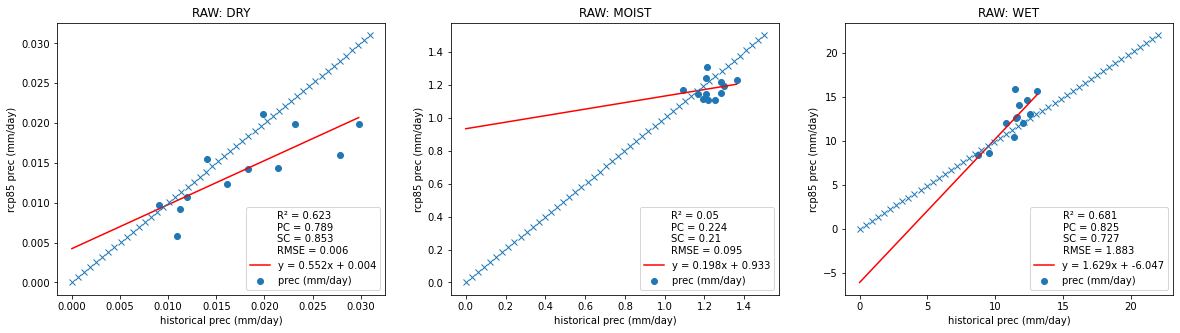

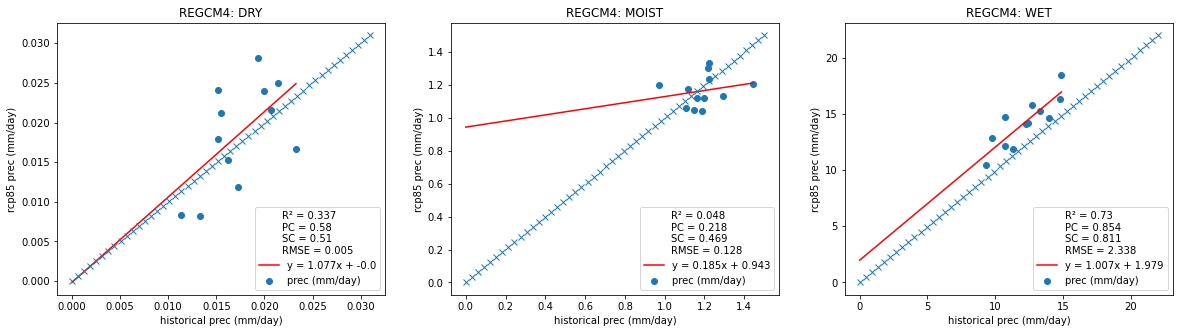

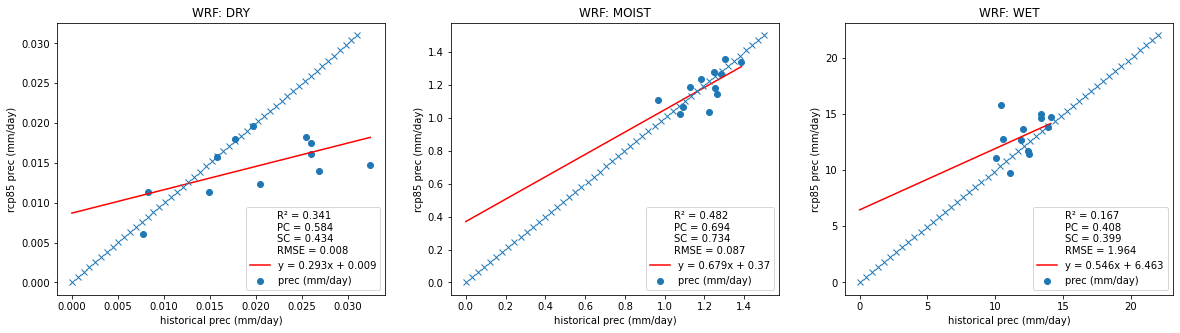

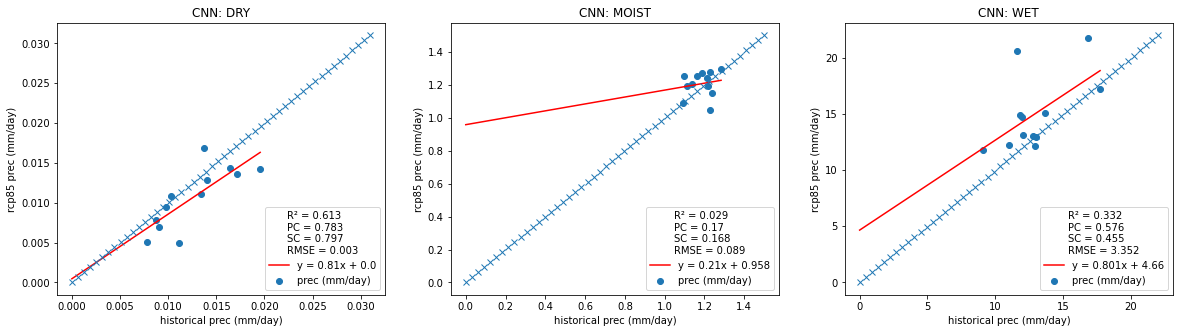

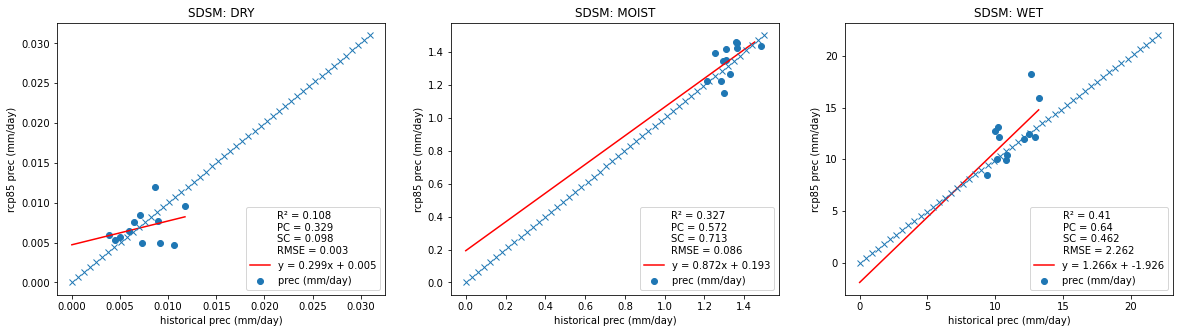

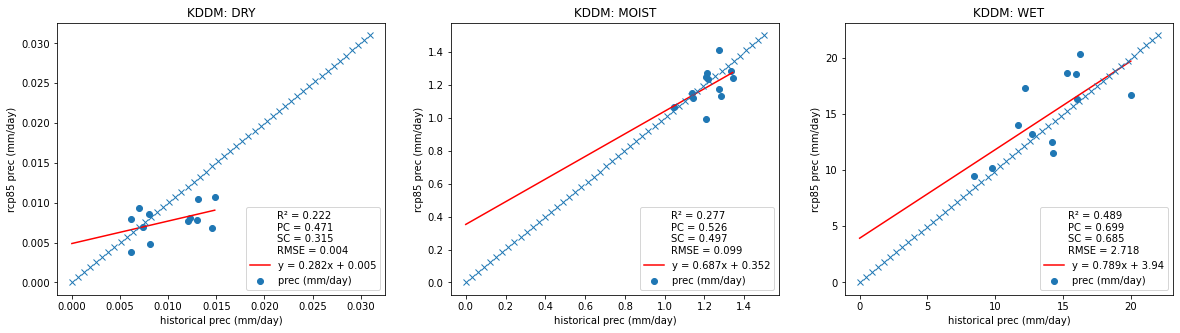

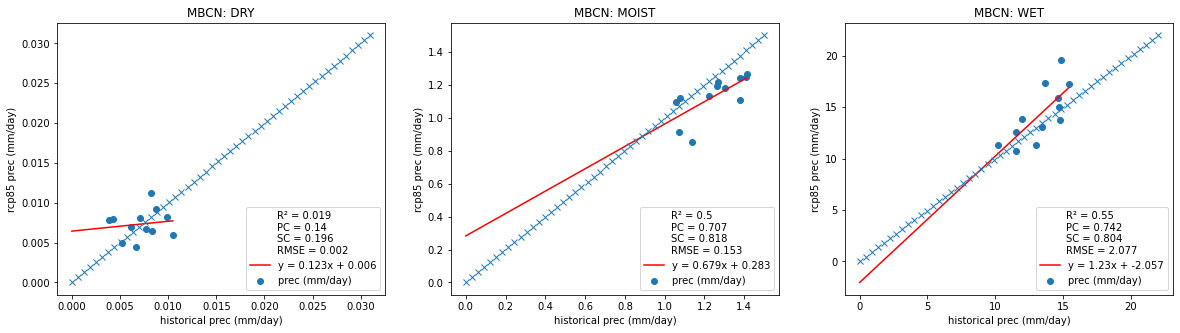

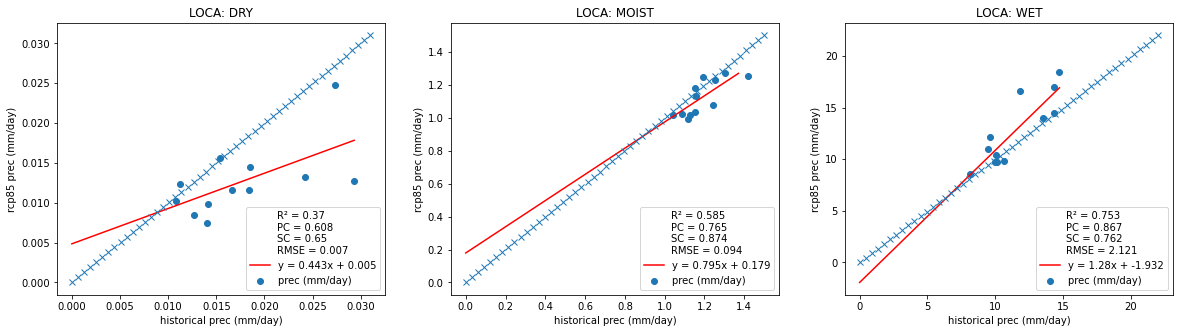

In [48]:
# Plot ALL models
#[model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

# interate every model
for mii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[mii]
    sigfn2 = sigfiles_rcp85[mii]

    rainsignal1 = xr.open_dataset(sigfn1)['prec']
    rainsignal2 = xr.open_dataset(sigfn2)['prec']


    # get averages for each of the twelve months
    XX=[]; YY=[]
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0)]:
        X=[]; Y=[]
        for ii in range(1,13):
            avginput1, count1, distribution1, indices1 = calc_prec_average(mpr_min, mpr_max, rainsignal1, ii, -9999, 9999) 
            avginput2, count2, distribution2, indices2 = calc_prec_average(mpr_min, mpr_max, rainsignal2, ii, -9999, 9999) 
            X.append(float(avginput1))
            Y.append(float(avginput2))
        XX.append(X)
        YY.append(Y)

    # plot row
    fig, axarr = plt.subplots(1, 3, figsize = (20,20/4))
    mname = names[mii]
    plot_scatter_row(XX[0], YY[0], axarr[0], mname+': dry', .031)
    plot_scatter_row(XX[1], YY[1], axarr[1], mname+': moist', 1.5)
    plot_scatter_row(XX[2], YY[2], axarr[2], mname+': wet', 22)
    plt.show()
    

### HIST vs. FUTURE

In [50]:
# HIST vs FUTURE

#[model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]

sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfn1 = sigfiles_hist[0]
sigfn2 = sigfiles_rcp85[0]

rainsignal1 = xr.open_dataset(sigfn1)['prec']
rainsignal2 = xr.open_dataset(sigfn2)['prec']


# interate every model
XX=[]; YY=[]
for mii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[mii]
    sigfn2 = sigfiles_rcp85[mii]

    rainsignal1 = xr.open_dataset(sigfn1)['prec']
    rainsignal2 = xr.open_dataset(sigfn2)['prec']

    # get averages for each of the twelve months
    X=[]; Y=[]
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0)]:
        avginput1, count1, distribution1, indices1 = calc_prec_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
        avginput2, count2, distribution2, indices2 = calc_prec_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
        X.append(float(avginput1))
        Y.append(float(avginput2))
    XX.append(X)
    YY.append(Y)
    print(X, Y)


[0.029797572642564774, 1.2972118854522705, 10.812373161315918] [0.01993877999484539, 1.194233775138855, 11.996299743652344]
[0.019958218559622765, 1.2237801551818848, 14.880117416381836] [0.0240038949996233, 1.3314791917800903, 18.49971580505371]
[0.025427045300602913, 1.385020136833191, 13.355270385742188] [0.018242888152599335, 1.3382331132888794, 14.992368698120117]
[0.01956319436430931, 1.1639140844345093, 13.66250991821289] [0.014185821637511253, 1.2548773288726807, 15.089552879333496]
[0.010634824633598328, 1.3579655885696411, 9.94668960571289] [0.0047411490231752396, 1.4592456817626953, 12.71196460723877]
[0.012278249487280846, 1.2112849950790405, 15.967031478881836] [0.008136054500937462, 1.269968032836914, 18.575885772705078]
[0.007694782689213753, 1.2700670957565308, 14.606186866760254] [0.006710864137858152, 1.2183786630630493, 15.900899887084961]
[0.024187644943594933, 1.1902779340744019, 13.54931926727295] [0.013271589763462543, 1.2461310625076294, 14.01877498626709]


In [51]:
np.array(XX)[:,0].shape

(8,)

In [52]:
np.array(XX)[:,0]

array([0.02979757, 0.01995822, 0.02542705, 0.01956319, 0.01063482,
       0.01227825, 0.00769478, 0.02418764])

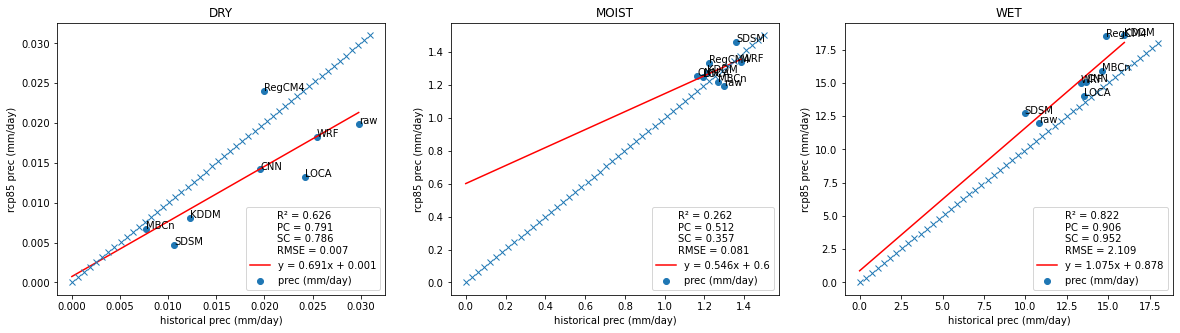

In [53]:
names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']

fig, axarr = plt.subplots(1, 3, figsize = (20,20/4))
mname = 'raw'
plot_scatter_row(np.array(XX)[:,0], np.array(YY)[:,0], axarr[0], 'Dry', .031)
for ii, txt in enumerate(names):
    axarr[0].annotate(txt, (np.array(XX)[ii,0], np.array(YY)[ii,0]))
    
plot_scatter_row(np.array(XX)[:,1], np.array(YY)[:,1], axarr[1], 'Moist', 1.5)
for ii, txt in enumerate(names):
    axarr[1].annotate(txt, (np.array(XX)[ii,1], np.array(YY)[ii,1]))
    
plot_scatter_row(np.array(XX)[:,2], np.array(YY)[:,2], axarr[2], 'Wet', 18)
for ii, txt in enumerate(names):
    axarr[2].annotate(txt, (np.array(XX)[ii,2], np.array(YY)[ii,2]))

plt.show()

In [54]:
3

3